# SAS Event Stream Processing Python Interface

ESPPy is a pure Python package to connect to a SAS Event Stream Processing (ESP) server using the REST interface and web sockets.

## Import the ESPPy Package and Create a Connection

In [1]:
import esppy
from esppy.espapi.visuals import Visuals

Set the server_url to point to your ESP server

In [2]:
server_url = "http://<host>:<port>"

In [3]:
esppy.ESP?

Init signature:
esppy.ESP(
    hostname=None,
    port=None,
    username=None,
    password=None,
    protocol=None,
    ca_bundle=None,
    authinfo=None,
    auth_obj=None,
)
Docstring:     
ESP Connection

Parameters
----------
hostname : string, optional
    Hostname of ESP server or ESP connection URL
port : int, optional
    Port number of ESP server.  This is not needed if
    a URL is used in the first parameter.
username : string, optional
    Username for authentication
password : string, optional
    Password for authentication.  If a password is specified,
    without a username, this is assumed to be an OAUTH token.
protocol : string, optional
    The protocol to use: http or https.  This is not
    needed if a URL is used in the first parameter.
ca_bundle : string, optional
    Path to the certificate bundle if using SSL
authinfo : string, optional
    Path to the authinfo file containing authentication
    information.

Attributes
----------
metadata : dict
    ESP engi

In [4]:
esp = esppy.ESP(server_url)
esp

ESP('http://espsrv01:7777')

Tab-completion will show all of the methods and attributes on the ESP object.

In [5]:
# esp.

## Create the server connection and visuals

In [6]:
conn = esp.createServerConnection()
visuals = Visuals()

## Server Introspection

In [7]:
esp.server_info

{'version': '7.1',
 'engine': 'fc93e451-b86e-4128-8716-2268248d8da9',
 'analytics-license': True,
 'primary-server': True,
 'pubsub': 7778,
 'http': 7777,
 'loglevel': 'common.http=debug,server.connection=debug',
 'nocleanup': None}

In [8]:
esp.get_projects()

{'primary': Project(name='primary'), 'secondary': Project(name='secondary')}

## Load a Project

In [9]:
%%sh
cat model_walking.xml

<engine>
  <projects>
    <project name='project' pubsub='auto' threads='1' use-tagged-token='true'>
      <contqueries>
        <contquery name='contquery' trace='w_data w_calculate'>
          <windows>
            <window-source name='w_data' insert-only='true'>
              <schema>
                <fields>
                  <field name='id'   type='int64' key='true'/>
                  <field name='time' type='double'/>
                  <field name='x'    type='double'/>
                  <field name='y'    type='double'/>
                  <field name='z'    type='double'/>
                </fields>
              </schema>
            </window-source>
            <window-source name='w_request' insert-only='true'>
              <schema>
                <fields>
                  <field name='req_id'  type='int64' key='true'/>
                  <field name='req_key' type='string'/>
                  <field name='req_val' type='string'/>
                </fields>
              </

Projects can be loaded from file paths, Python file objects, or URLs.  They can also be loaded from Python `Project` objects as we will see later in this notebook.

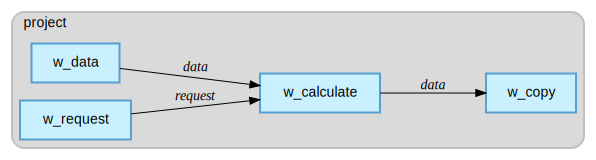

In [10]:
walk = esp.load_project('model_walking.xml')
walk

In [11]:
str(walk)

"Project(name='project')"

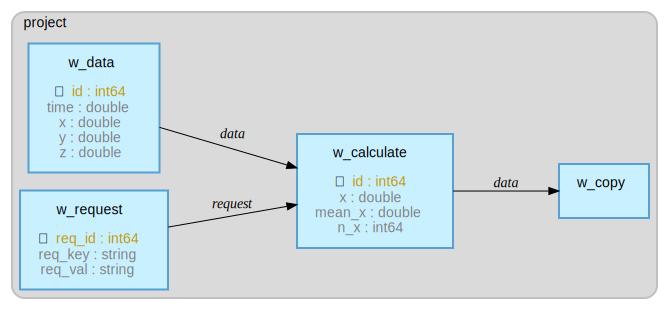

In [12]:
walk.to_graph(schema=True)

### Get References to Project Components

In [13]:
walk.queries

{'contquery': ContinuousQuery(name='contquery', project='project')}

In [14]:
walk.queries['contquery'].windows

{'w_data': SourceWindow(name='w_data', contquery='contquery', project='project'), 'w_request': SourceWindow(name='w_request', contquery='contquery', project='project'), 'w_calculate': CalculateWindow(name='w_calculate', contquery='contquery', project='project'), 'w_copy': CopyWindow(name='w_copy', contquery='contquery', project='project')}

Specifying `queries` and `windows` is optional.  The `Project` and `ContinuousQuery` objects act like dictionaries so you can access the sub-objects directly using indexing. 

In [15]:
dataw = walk.queries['contquery'].windows['w_data']
calcw = walk['contquery']['w_calculate']
copyw = walk['contquery']['w_copy']

In [16]:
str(dataw)

"SourceWindow(name='w_data', contquery='contquery', project='project')"

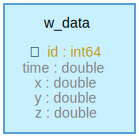

In [17]:
dataw.to_graph()

In [18]:
# dataw.

## Event Generators

In [19]:
%%sh
head model_walking.csv

I,N,1,0,0.69464,3.1735,7.5048
I,N,2,0.030639,0.14982,3.4868,9.2755
I,N,3,0.069763,-0.29965,1.9477,9.112
I,N,4,0.099823,-1.6889,1.4165,10.12
I,N,5,0.12982,-2.1793,0.95342,10.924
I,N,6,0.15979,-2.3018,0.23155,10.651
I,N,7,0.18982,-1.4165,1.185,11.073
I,N,8,0.2204,-0.27241,2.2201,11.986
I,N,9,0.24976,-0.61292,2.2201,11.986
I,N,10,0.27972,1.3348,4.2495,11.414


In [20]:
import os

# Using a URL path means the file must be accesible on the server-side
egen = dataw.create_event_generator('file:///%s' % os.path.abspath('model_walking.csv'))
egen

EventGenerator(name='eg_sbw3zz0tw1', publish_target='dfESP://espsrv01:7778/project/contquery/w_data')

In [21]:
egen.start(pause=200)

## Streaming DataFrames

In [22]:
dataw.subscribe(limit=20)

You may have to wait a couple of seconds for the data to show up here.  If you execute the cell repeatedly, it will show the new events added each time.

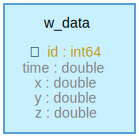

In [23]:
dataw

### Using DataFrame Plotting Features

In [24]:
%matplotlib inline

/mnt/data/share/install/anaconda3/envs/esp/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning:

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.



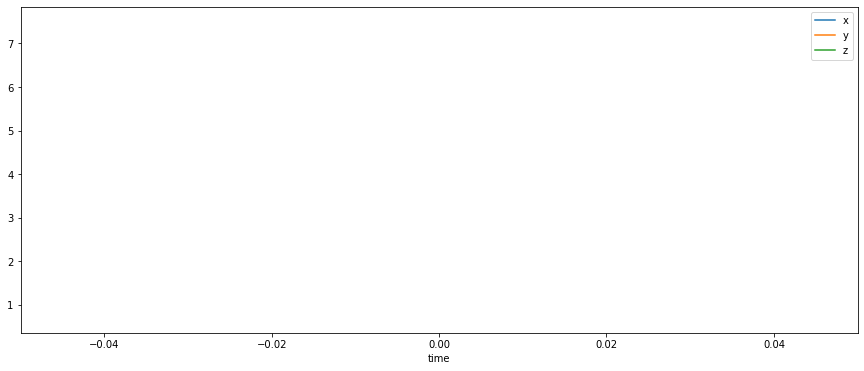

In [25]:
dataw.sort_values('time', ascending=True).plot('time', ['x', 'y', 'z'], figsize=(15, 6))

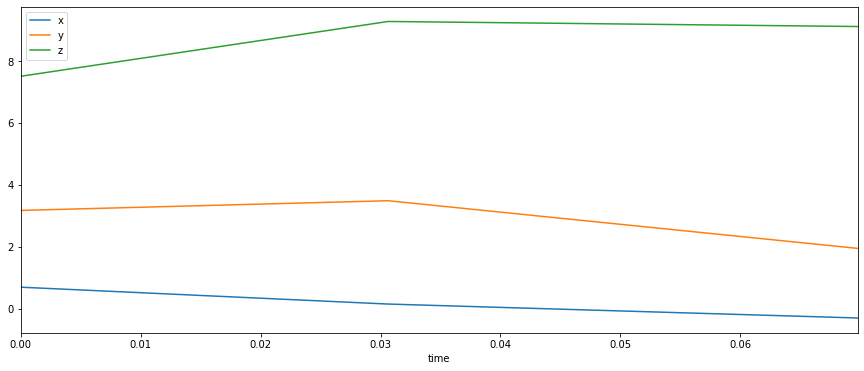

In [26]:
dataw.sort_values('time', ascending=True).plot('time', ['x', 'y', 'z'], figsize=(15, 6))

## Streaming Figures

In [27]:
stream = conn.getEventStream(dataw,ignore_deletes=True,maxevents=5)
line = visuals.createLineChart(stream,x="time",y=["x","y","z"],width="600",yrange=[-16,16],line_width=4,curved=True)
line

LineChart(children=(VBox(children=(HTML(value="<div style='font-size:12pt;text-align:center'>project/contquery…

In [28]:
## Create a New Project Programmatically

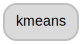

In [29]:
proj = esp.create_project('kmeans')
proj

### Add a Source Window

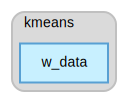

In [30]:
src = esp.SourceWindow(schema=('id*:int64', 'x_c:double', 'y_c:double'),
                       index_type='pi_EMPTY', insert_only=True)
proj.windows['w_data'] = src
proj

### Add a Training Window

Using tab-completion here, you can see all of the training windows available on your ESP server.

In [31]:
# esp.train.

Using the help system, you can see what parameters are available on each window.

In [32]:
esp.train.KMEANS?

Init signature:
esp.train.KMEANS(
    name=None,
    pubsub=None,
    commitInterval=25,
    dampingFactor=0.8,
    disturbFactor=0.01,
    fadeOutFactor=0.05,
    initSeed=12345,
    nClusters=2,
    nInit=50,
    velocity=1,
    input_map=None,
)
Docstring:     
KMEANS

Parameters
----------
name : string, optional
    The name of the window
commitInterval : int64, optional
    Specifies the number of timestamps to be elapsed before triggering a commit
    of model to downstream scoring.
dampingFactor : double, optional
    Specifies the damping factor \alpha (0<=\alpha<=1) for old data points.
disturbFactor : double, optional
    Specifies the factor \delta (\delta >0) for the disturbance when splitting a
    cluster.
fadeOutFactor : double, optional
    Specifies the factor \theta (0<\theta<1) for determining whether an existing
    cluster is fading out.
initSeed : int32, optional
    Specifies the random seed used during initialization when each points is
    assigned to a random

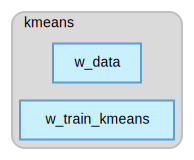

In [33]:
train = esp.train.KMEANS(
    velocity=5, fadeOutFactor=0.05, nClusters=2, dampingFactor=0.8, 
    nInit=50, commitInterval=25, initSeed=1, disturbFactor=0.01,
    input_map=dict(inputs=('x_c', 'y_c')))
proj.windows['w_train_kmeans'] = train
proj

### Add a Scoring Window

In [34]:
# esp.score.

In [35]:
esp.score.KMEANS?

Init signature:
esp.score.KMEANS(
    name=None,
    schema=None,
    copyvars=None,
    pubsub=None,
    input_map=None,
    output_map=None,
)
Docstring:     
KMEANS

Parameters
----------
name : string, optional
    The name of the window
input_map : dict, optional
    The input variable map entries
output_map : dict, optional
    The output variable map entries

See Also
--------
set_inputs
set_outputs

Notes
-----
** Input Map Entries **

inputs : list-of-strings
    Specifies the list of variable names used in clustering.

** Output Map Entries **

labelOut : string
    Specifies the output variable name in the output schema that stores cluster
    label.
minDistanceOut : string
    Specifies the output variable name in the output schema that stores the
    distance to the nearest cluster. if not specified
modelIdOut : string
    Specifies the output variable name in the output schema that stores the id
    of the model from which the score is computed. if not specified
File:    

In [36]:
esp.score.KMEANS.output_map_types

{'labelOut': 'int32', 'minDistanceOut': 'double', 'modelIdOut': 'int64'}

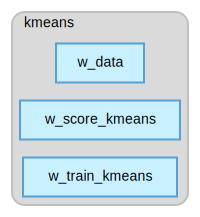

In [37]:
score = esp.score.KMEANS(
    schema=('id*:int64', 'x_c:double', 'y_c:double', 'min_dist:double', 'seg:int32', 'model_id:int64'),
    input_map=dict(inputs=('x_c', 'y_c')),
    output_map=dict(minDistanceOut='min_dist', labelOut='seg', modelIdOut='model_id')
)
proj.windows['w_score_kmeans'] = score
proj

### Make Connection Between Windows

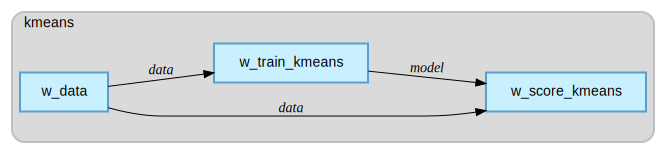

In [38]:
src.add_target(score, role='data')
src.add_target(train, role='data')
train.add_target(score, role='model')
proj

### Preview the Project's XML Definition

In [39]:
print(proj.to_xml(pretty=True))

<engine>
  <projects>
    <project name="kmeans" pubsub="auto" threads="1">
      <contqueries>
        <contquery name="contquery">
          <windows>
            <window-source index="pi_EMPTY" insert-only="true" name="w_data">
              <schema>
                <fields>
                  <field key="true" name="id" type="int64" />
                  <field key="false" name="x_c" type="double" />
                  <field key="false" name="y_c" type="double" />
                </fields>
              </schema>
            </window-source>
            <window-score name="w_score_kmeans">
              <schema>
                <fields>
                  <field key="true" name="id" type="int64" />
                  <field key="false" name="x_c" type="double" />
                  <field key="false" name="y_c" type="double" />
                  <field key="false" name="min_dist" type="double" />
                  <field key="false" name="seg" type="int32" />
                  <field ke

### Display a Graph of the Project

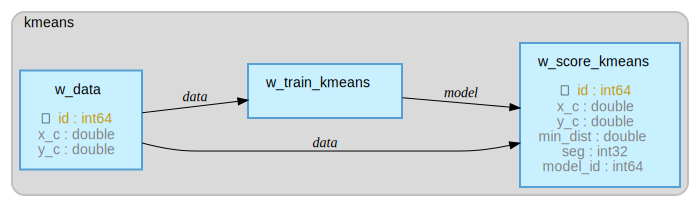

In [40]:
proj.to_graph(schema=True)

## Load the Project into the Server

In [41]:
esp.load_project(proj);

In [42]:
esp.get_projects()

{'kmeans': Project(name='kmeans'),
 'primary': Project(name='primary'),
 'project': Project(name='project'),
 'secondary': Project(name='secondary')}

### Publish Events to Source Window

In [43]:
%%sh
head basics.csv

i,n,0,0.5908967210216602,1.6751986326790076
i,n,1,19.043415721883388,18.371355627504236
i,n,2,-0.012273367464207865,-0.4540492269435668
i,n,3,17.97874517980503,21.65120582597203
i,n,4,1.1659924204397523,-1.2409508065225885
i,n,5,0.8546216190275081,-0.25882119862607184
i,n,6,20.190217162336587,22.50997309914134
i,n,7,-0.25895458090747875,1.4976085871983391
i,n,8,22.29022654822051,16.914962015510373
i,n,9,20.77677573497869,19.816778938696523


Use pandas to transform data before publishing it.  Notice that the DataFrame can contain additional columns, and columns out-of-order.  Only the columns in the DataFrame that match the columns in the window schema are uploaded.

In [44]:
import pandas as pd

df = pd.read_csv('basics.csv', header=None, names=['opcode', 'opmode', 'id', 'x_c', 'y_c'])

df['extra'] = df['x_c']**2 + df['y_c']**2
df = df[['id', 'y_c', 'extra', 'x_c', 'opcode', 'opmode']]
df = df.set_index('id')

df.head()

,y_c,extra,x_c,opcode,opmode
id,,,,,
0,1.675199,3.155449,0.590897,i,n
1,18.371356,700.158390,19.043416,i,n
2,-0.454049,0.206311,-0.012273,i,n
3,21.651206,792.009992,17.978745,i,n
4,-1.240951,2.899497,1.165992,i,n


In [45]:
src.publish_events(df, pause=200)

In [46]:
src.subscribe()
score.subscribe()

In [47]:
src.tail(10)

,x_c,y_c
id,,


This window may take several seconds before the scoring window events start to show up.

In [48]:
score.tail(10)

,x_c,y_c,min_dist,seg,model_id
id,,,,,


## Plot the Streaming Data

This function is used to generate the legend and colors for each of the `x_c` / `y_c` data points.

In [49]:
class_map = dict(
    seg=dict(
        class_label={0: 'Class 1', 1: 'Class 2'},
        class_color={0: '#68b0e3b2', 1: '#d37a2db2'},
    )   
)

# Alternatively
def class_map_func(event):
    seg = event['seg']
    return dict(
        class_label=seg.map({0: 'Class 1', 1: 'Class 2'}),
        class_color=seg.map({0: '#68b0e3b2', 1: '#d37a2db2'}),
    )

### Start the streaming scatter plot.

In [50]:
scoreStream = conn.getEventStream(score,maxevents=10)
scoreChart = visuals.createScatterPlot(scoreStream,x="x_c",y="y_c",xrange=[-15,30],yrange=[-15,30])
scoreChart

ScatterPlot(children=(VBox(children=(HTML(value="<div style='font-size:12pt;text-align:center'>kmeans/contquer…

## Client-side Transformers

Transformers can be any DataFrame operation.

In [51]:
score.add_event_transformer('abs')
score.add_event_transformer('clip', upper=20)

Or, they can be functions that can do any arbitrary operation.

In [52]:
def dist_group(event):
    event['dist_group'] = event['min_dist'] > 10
    return event

score.add_event_transformer(dist_group)

In [53]:
score.head(10)

,x_c,y_c,min_dist,seg,model_id,dist_group
id,,,,,,
